## 1. Data augmentation by procedural adversarial noise

## 2. End-to-end information-extreme optimization of hypersherical decision boundaries for each class in binarized embedding space

In [ ]:
dataset_dir_path = 'context_dataset_originals_v1.0/context_dataset_originals/'
class_num = 12 # len(os.listdir(dataset_dir_path))
output_dim = 128
image_size = 224
batch_size = 512
initial_learning_rate = 1e-3
epochs = 50
weight_decay = 0.001

# result path
path_to_feature_extractor = 'gdrive/MyDrive/feature_extractor.h5'
path_to_prototypes        = 'gdrive/MyDrive/prototypes.csv'
path_to_radiuses          = 'gdrive/MyDrive/radiuses.csv'

## load labeled data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!cp '/content/gdrive/MyDrive/context_dataset_originals_v1.0.zip' '/content/context_dataset_originals_v1.0.zip'
!unzip  '/content/context_dataset_originals_v1.0.zip' -d 'context_dataset_originals_v1.0'

Показано результат, скорочений до останніх рядків (5000).
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S033-066_S033-055_20200903_U_TBC_45.5.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S033-602_S033-044_20200806_U_TFC_164.6.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S034-070_S034-069_20200803_D_TFC_148.6.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S034-253_S034-255_20200730_D_TFC_55.7.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S035-280_S035-281_20170811_U_TFC_131.1.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S035-321_S035-322_20170811_U_TFC_49.1.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_originals/tap_capped/S035-322_S035-319_20200811_D_TFC_95.3.jpg  
  inflating: context_dataset_originals_v1.0/context_dataset_orig

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio( dataset_dir_path, 
                    output="output", ratio=(.8, 0.1,  0.1)) 

Copying files: 72004 files [00:29, 2436.03 files/s]


## data augmentation operations

In [ ]:
!pip install noise

     |████████████████████████████████| 132 kB 5.1 MB/s 
  Created wheel for noise: filename=noise-1.2.2-cp37-cp37m-linux_x86_64.whl size=64364 sha256=a461c98c8c24e73c9e27249fc27ad0c4ffff305807c01ceef1b03891fb93d681
  Stored in directory: /root/.cache/pip/wheels/50/4f/1d/3e94460751c993553ba1a52b8e571ba6510701b4d0a68ffeea
Successfully built noise


In [ ]:
import cv2
import random
import numpy as np
from noise import pnoise2

def normalize_var(orig):
    size = orig.shape[0]
    # Spectral variance
    mean = np.mean(orig)
    spec_var = np.fft.fft2(np.square(orig -  mean))
    # Normalization
    imC = np.sqrt(abs(np.real(np.fft.ifft2(spec_var))))
    imC /= np.max(imC)
    minC = 0.001
    imK =  (minC + 1) / (minC + imC)
    img = mean + (orig -  mean) * imK    
    return normalize(img)

# Normalize vector
def normalize(vec):
    vmax = np.amax(vec)
    vmin  = np.amin(vec)
    return (vec - vmin) / (vmax - vmin)

# Valid positions for Gabor noise
def valid_position(size, x, y):
    if x < 0 or x >= size: return False
    if y < 0 or y >= size: return False
    return True

### Procedural Noise ###
# Note: Do not take these as optimized implementations.
'''
Gabor kernel
sigma       variance of gaussian envelope
theta         orientation
lambd       sinusoid wavelength, bandwidth
xy_ratio    value of x/y
psi            phase shift of cosine in kernel
sides        number of directions
'''
def gaborK(ksize, sigma, theta, lambd, xy_ratio, sides):
    gabor_kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, xy_ratio, 0, ktype = cv2.CV_32F)
    for i in range(1, sides):
        gabor_kern += cv2.getGaborKernel((ksize, ksize), sigma, theta + np.pi * i / sides, lambd, xy_ratio, 0, ktype = cv2.CV_32F)
    return gabor_kern

'''
Gabor noise
- randomly distributed kernels
- anisotropic when sides = 1, pseudo-isotropic for larger "sides"
'''
def gaborN_rand(size, grid, num_kern, ksize, sigma, theta, lambd, xy_ratio = 1, sides = 1, seed = 0):
    np.random.seed(seed)
    # Gabor kernel
    if sides != 1: gabor_kern = gaborK(ksize, sigma, theta, lambd, xy_ratio, sides)
    else: gabor_kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, xy_ratio, 0, ktype = cv2.CV_32F)
    # Sparse convolution noise
    sp_conv = np.zeros([size, size])
    dim = int(size / 2 // grid)
    noise = []
    for i in range(-dim, dim + 1):
        for j in range(-dim, dim + 1):
            x = i * grid + size / 2 - grid / 2
            y = j * grid + size / 2 - grid / 2
            for _ in range(num_kern):
                dx = np.random.randint(0, grid)
                dy = np.random.randint(0, grid)
                while not valid_position(size, x + dx, y + dy):
                    dx = np.random.randint(0, grid)
                    dy = np.random.randint(0, grid)
                weight = np.random.random() * 2 - 1
                sp_conv[int(x + dx)][int(y + dy)] = weight
    
    sp_conv = cv2.filter2D(sp_conv, -1, gabor_kern)
    return normalize(sp_conv)

'''
Gabor noise
- controlled, uniformly distributed kernels
grid        ideally is odd and a factor of size
thetas    orientation of kernels, has length (size / grid)^2
'''
def gaborN_uni(size, grid, ksize, sigma, lambd, xy_ratio, thetas):
    sp_conv = np.zeros([size, size])
    temp_conv = np.zeros([size, size])
    dim = int(size / 2 // grid)
    
    for i in range(-dim, dim + 1):
        for j in range(-dim, dim + 1):
            x = i * grid + size // 2
            y = j * grid + size // 2
            temp_conv[x][y] = 1
            theta = thetas[(i + dim) * dim * 2 + (j + dim)]
            
            # Gabor kernel
            gabor_kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, xy_ratio, 0, ktype = cv2.CV_32F)
            sp_conv += cv2.filter2D(temp_conv, -1, gabor_kern)
            temp_conv[x][y] = 0
    
    return normalize(sp_conv)

'''
Perlin noise
- with sine color map
'''
def perlin(size, period, octave, freq_sine, lacunarity = 2):
    # Perlin noise
    noise = np.empty((size, size), dtype = np.float32)
    for x in range(size):
        for y in range(size):
            noise[x][y] = pnoise2(x / period, y / period, octaves = octave, lacunarity = lacunarity)  
    # Sine function color map
    noise = normalize(noise)
    noise = np.sin(noise * freq_sine * np.pi)
    return normalize(noise)

'''
Color noise
noise           has dimension 2 or 3, pixel range [0, 255]
color            is [a, b, c] where a, b, c are from {-1, 0, 1}
'''
def colorize(noise, color = [1, 1, 1]):
    if noise.ndim == 2: # expand to include color channels
        noise = np.expand_dims(noise, 2)
    return (noise - 0.5) * color * 2 # output pixel range [-1, 1]

'''
Perturb image and clip to maximum perturbation norm
img              image with pixel range [0, 1]
noise           noise with pixel range [-1, 1]
norm           L-infinity norm constraint
'''
def perturb(img, noise, norm):
    noise = np.sign((noise - 0.5) * 2) * norm
    noise = np.clip(noise, np.maximum(-img, -norm), np.minimum(255 - img, norm))
    return (img + noise)

# grid = default_value = 23, 14, ...  - Size of the grid the image is divided into.
# max_norm = [0, 64], default_value = 12 - L-infinity norm constraint 
# num_kern = [1, 200], defaut_value = 23   - Number of kernels added to each grid.
# ksize    = [1, 40], default_value = 23   - Size of each kernel. When kernel size is reduced to one, the resulting image will just be the sparse white noise.
# sigma    = [2, 20], default_value = 8 - Variance of the Gaussian.
# theta    = [0, np.pi], default_value = np.pi / 4 - Orientation or angle of the kernel.
# lambd    = [0.25, 20], default_value = 10 - Wavelength of the sinusoidal factor in the Harmonic kernel. In the spectral domain, this changes the distance between the lobes.
# color    = 'Black-White', 'Red-Cyan', 'Green-Magenta', 'Blue-Yellow'
def gabor_noise(image, max_norm=30, num_kern=23, ksize=23, sigma=8, 
                theta=np.pi / 4, lambd=10, grid=23, color = 'Black-White'): 
    if color == 'Black-White': coloring = [1, 1, 1]
    if color == 'Red-Cyan': coloring = [1, -1, -1]
    if color == 'Green-Magenta': coloring = [-1, 1, -1]
    if color == 'Blue-Yellow': coloring = [-1, -1, 1]
    # Noise pattern    
    noise = gaborN_rand(size = image_size, grid = grid, num_kern = num_kern, ksize = ksize, sigma = sigma, theta = theta, lambd = lambd)
    noise = normalize_var(noise)
    noise = colorize(noise, coloring)    
    # Altered image
    payload = perturb(img = image.astype(np.float), noise = noise, norm = max_norm)
    return payload.astype(np.uint8) #.astype(np.float).reshape((1, image_size, image_size, 3))
   
# max_norm   = [0, 64], default_value = 12 - L-infinity norm constraint
# period     = [2, 180], default_value = 60
# freq_sine  = [0,60] default_value = 36
# octave     = [1, 2, 3, 4]
def perlin_noise(image, max_norm=12, period=60, freq_sine=36, octave=3):
    # Noise pattern   
    noise = perlin(size = image_size, period = period, octave = octave, freq_sine = freq_sine)
    noise = colorize(noise)  # noise with pixel range [-1, 1]
    # Altered image
    payload = perturb(img = image.astype(np.float), norm = max_norm, noise = noise)
    return payload.astype(np.uint8) #.astype(np.float).reshape((1, image_size, image_size, 3))

def adversarial_augmentation(image):
    noise_type_flag = random.choice([True, False])
    if noise_type_flag :
        grid = random.randint(14, 24)       # default_value = 23, 14, 
        max_norm = random.randint(0, 64)    # default_value = 12 
        num_kern = random.randint(5, 150)   # defaut_value = 23  
        ksize    = random.randint(3, 40)    # default_value = 23   
        sigma    = random.randint(2, 20)    # default_value = 8 
        theta    = random.uniform(0, np.pi) # default_value = np.pi / 4 - Orientation or angle of the kernel.
        lambd    = random.uniform(0.25, 20) # default_value = 10 
        color    = random.choice(['Black-White', 'Red-Cyan', 'Green-Magenta', 'Blue-Yellow'])
        # generate perturbed image
        noised_img = gabor_noise(image, max_norm=30, num_kern=23, 
                                 ksize=23, sigma=8, theta=np.pi / 4, 
                                 lambd=10, grid=23, color = 'Black-White')
    else :
        max_norm_v   = random.randint(0, 64)  # default_value = 12 
        period_v     = random.randint(2, 180) # default_value = 60
        freq_sine_v  = random.randint(0, 60)  # default_value = 36
        octave_v     = random.randint(1, 4)   #
        # generate perturbed image
        noised_img = perlin_noise(image, max_norm=max_norm_v, period=period_v, 
                                  freq_sine=freq_sine_v, octave=octave_v)
    return noised_img

In [ ]:
import cv2
import numpy as np
from noise import pnoise2
import random

def adversarial_preprocessor(image):
    image = adversarial_augmentation(image)
    return tf.keras.applications.mobilenet.preprocess_input(image)

In [ ]:
from datetime import datetime
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight

#****************************************                       

dg = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=adversarial_preprocessor, #tf.keras.applications.mobilenet.preprocess_input,
)

train_ds = dg.flow_from_directory(
    directory='/content/output/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode= 'categorical',
    seed=42
)

test_ds = dg.flow_from_directory(
    directory='/content/output/val',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode= 'categorical',
    seed=42
)

#****************************************

dg2 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=None, 
)

train_ds2 = dg.flow_from_directory(
    directory='/content/output/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

test_ds2 = dg.flow_from_directory(
    directory='/content/output/val',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

def convert_generator_to_input_2(image_data_gen):
    for image, label in image_data_gen:
        yield [label, np.array([0])]

train_dds = convert_generator_to_input_2(train_ds2)
test_dds = convert_generator_to_input_2(test_ds2)

#****************************************

early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=0,
                                                  verbose=1, mode='auto', cooldown=0, min_lr=1e-15)
cbs = [early_stop, reduce_lr]

Found 57600 images belonging to 12 classes.
Found 7195 images belonging to 12 classes.
Found 57600 images belonging to 12 classes.
Found 7195 images belonging to 12 classes.


## Encoder architecture

In [ ]:
#**************************************************************************
#************************  base_feature_extractor.py  *********************
#**************************************************************************

# Define the encoder architecture
def get_encoder():
    extractor = tf.keras.applications.MobileNet(           
            input_shape=(image_size, image_size, 3),
            alpha=0.5, 
            include_top=False, 
            weights='imagenet' )
    inputs = extractor.output
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    outputs = tf.keras.layers.Dense(output_dim, activation="relu", use_bias=False)(x)
    return tf.keras.Model(extractor.input, outputs, name="encoder") 

## feature extractor tuning and train prototypes

In [ ]:
#**************************************************************************
#************************  prototype_layer.py  ****************************
#**************************************************************************
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from scipy.linalg import hadamard
from math import log2, ceil

class HadamardInitializer(tf.keras.initializers.Initializer):

    def __init__(self, ):
        pass

    def __call__(self, shape, dtype=None):
        init_matrix = hadamard(pow(2, ceil(log2(shape[1]))))
        init_matrix[init_matrix<0]=0
        init_matrix = init_matrix.astype(np.float32)
        init_matrix[init_matrix==0]=0.2
        init_matrix[init_matrix==1]=0.8
        init_matrix = init_matrix[0:shape[0], 0:shape[1]]
        init_matrix = tf.Variable(init_matrix)
        return init_matrix

    def get_config(self):  # To support serialization
        return {}

class PlotkinBoundInitializer(tf.keras.initializers.Initializer):

    def __init__(self, class_num):
        self.class_num = class_num
        # container radius as half of Plotkin’s Bound
        self.r = 0.25 * class_num / (class_num-1) 

    def __call__(self, shape, dtype=None):
        vector = np.ones((self.class_num,))*self.r
        init_vector = tf.Variable(vector, dtype=tf.float32)
        return init_vector

    def get_config(self):  # To support serialization
        return {}

### special layer
class BinarizedPrototypeLoss(tf.keras.layers.Layer):
  
    def __init__(self, num_classes=2, dim_hidden=1, lambda_c=1.0, **kwargs):
        super().__init__(**kwargs)
        self.dim_hidden  = dim_hidden
        self.num_classes = num_classes
        self.lambda_c    = tf.constant(lambda_c, dtype=tf.float32)       
        self.epsilon     = tf.constant(1e-6, dtype=tf.float32)
        self.one         = tf.constant(1.0, dtype=tf.float32)
        self.dim         = tf.constant(self.dim_hidden, dtype=tf.float32)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.num_classes, self.dim_hidden),
                                       initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), #HadamardInitializer(),
                                       trainable=True)   
        self.radiuses = self.add_weight(name='radiuses',
                                       shape=(self.num_classes,),
                                       initializer = PlotkinBoundInitializer(self.num_classes), #tf.keras.initializers.RandomUniform(minval=0., maxval=1.), 
                                       trainable=True)   
        super().build(input_shape)

    def call(self, inputs, mask=None):
        embedding, labels   = inputs[0], inputs[1]
        labels_int          = tf.math.argmax(labels, axis=1) 
        batch_size          = embedding.shape[0]
        if batch_size is None:
            batch_size = 1
        expanded_centers    = tf.expand_dims(self.centers, axis=0)   
        expanded_centers    = tf.repeat( expanded_centers, repeats=[batch_size], axis=0 )        
        expanded_embedding  = tf.expand_dims( embedding, axis=1 )
        expanded_embedding  = tf.repeat( expanded_embedding, repeats=[self.num_classes], axis=1 ) 
        distance_centers    = tf.math.squared_difference( expanded_embedding, expanded_centers )
        distance_centers    = tf.math.reduce_sum( distance_centers, axis=2 )

        # contrastive center 
        distances_intra     = tf.gather( distance_centers, indices=tf.expand_dims(labels_int, axis=1), batch_dims=1 )
        distances_sum       = tf.math.reduce_sum( distance_centers, axis=1 )
        distances_sum       = tf.expand_dims( distances_sum, axis=0 )
        distances_sum       = tf.transpose( distances_sum )
        distance_inter      = distances_sum - distances_intra
        loss1               = (distances_intra + self.one)/( distance_inter + self.one) #self.lambda_c ) 

        # macro soft f1
        y       = tf.cast(labels, tf.float32) 
        y_hat   = tf.math.sigmoid( 1.0*(self.one-(distance_centers /(self.dim*self.radiuses) )) )
        tp      = tf.reduce_sum(y_hat * y, axis=0)
        tn      = tf.reduce_sum((self.one - y_hat) * (self.one - y), axis=0)
        fp      = tf.reduce_sum(y_hat * (self.one - y), axis=0)
        fn      = tf.reduce_sum((self.one - y_hat) * y, axis=0)
        soft_f1 = 2*tp / (2*tp + fn + fp + self.epsilon)
        cost    = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
        loss2   = tf.reduce_mean(cost)
      
        # regularization for output discritization
        e                   = tf.ones([batch_size, self.dim_hidden] )
        dif                 = tf.linalg.matmul(embedding, e-embedding, transpose_b=True)
        loss3               = tf.linalg.tensor_diag_part(dif)
        loss3               = tf.expand_dims(loss3, axis=0)  
        loss3               = tf.transpose(loss3)
        
        return loss1 + loss2 + 0.01*loss3 + 0.01*tf.reduce_mean(self.radiuses) + self.centers

    def compute_output_shape(self, input_shape):
        return tf.compat.v1.keras.backend.int_shape(self.loss)

class InformationExtremeLoss(tf.keras.layers.Layer):
  
    def __init__(self, num_classes=2, dim_hidden=1, lambda_c=1.0, **kwargs):
        super().__init__(**kwargs)
        self.dim_hidden  = dim_hidden
        self.num_classes = num_classes
        self.lambda_c    = tf.constant( lambda_c, dtype=tf.float32 )       
        self.epsilon     = tf.constant( 1e-6, dtype=tf.float32 )
        self.one         = tf.constant( 1.0, dtype=tf.float32 )
        self.dim         = tf.constant( self.dim_hidden, dtype=tf.float32 )
        self.dn          = tf.constant( (self.num_classes-1)*(self.num_classes-1)*self.dim_hidden, dtype=tf.float32 )

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.num_classes, self.dim_hidden),
                                       initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), #HadamardInitializer(),
                                       trainable=True)   
        self.radiuses = self.add_weight(name='radiuses',
                                       shape=(self.num_classes,),
                                       initializer = PlotkinBoundInitializer(self.num_classes), #tf.keras.initializers.RandomUniform(minval=0., maxval=1.), 
                                       trainable=True)   
        super().build(input_shape)

    def call(self, inputs, mask=None):
        embedding, labels   = inputs[0], inputs[1]
        labels_int          = tf.math.argmax(labels, axis=1) 
        batch_size          = embedding.shape[0]
        if batch_size is None:
            batch_size = 1
        expanded_centers    = tf.expand_dims(self.centers, axis=0)   
        expanded_centers    = tf.repeat( expanded_centers, repeats=[batch_size], axis=0 )        
        expanded_embedding  = tf.expand_dims( embedding, axis=1 )
        expanded_embedding  = tf.repeat( expanded_embedding, repeats=[self.num_classes], axis=1 ) 
        distance_centers    = tf.math.squared_difference( expanded_embedding, expanded_centers )
        distance_centers    = tf.math.reduce_sum( distance_centers, axis=2 )

        # Shannon information criterion
        y       = tf.cast(labels, tf.float32) #* 0.8 + 0.1 # label smoothing
        u       = self.one-distance_centers /(self.dim*self.radiuses+self.epsilon) #tf.pow(( ), 2)
        y_hat   = tf.nn.relu(u) # tf.math.maximum(u, 0) # tf.math.sigmoid(u*6)
        #y_hat   = tf.nn.softmax(y_hat) 
        
        #loss1   = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=u)
        #loss1   = tf.expand_dims(loss1, axis=0)  
        #loss1   = tf.transpose(loss1)

        tp      = tf.reduce_sum(y_hat * y, axis=0)
        tn      = tf.reduce_sum((self.one - y_hat) * (self.one - y), axis=0)
        fp      = tf.reduce_sum(y_hat * (self.one - y), axis=0)
        fn      = tf.reduce_sum((self.one - y_hat) * y, axis=0)

        D1        = tp/(tp + fn + self.epsilon) + self.epsilon # sensitivity
        D2        = tn/(tn + fp + self.epsilon) + self.epsilon # specificity
        alpha     = fn/(fn + tp + self.epsilon) + self.epsilon # miss rate
        betta     = fp/(fp + tn + self.epsilon) + self.epsilon # fall-out rate
        
        D1        = tf.math.maximum(D1, 0.5)     # move to admissible domain  #tf.nn.relu
        D2        = tf.math.maximum(D2, 0.5)     # move to admissible domain
        alpha     = tf.math.minimum(alpha, 0.5)  # move to admissible domain
        betta     = tf.math.minimum(betta, 0.5)  # move to admissible domain
        
        c1        = alpha/(alpha+D2)
        c2        = betta/(betta+D1)
        c3        = D1/(D1+betta)
        c4        = D2/(D2+alpha)

        shannon   =  c1*tf.math.log(c1 + self.epsilon ) 
        shannon   += c2*tf.math.log(c2 + self.epsilon )
        shannon   += c3*tf.math.log(c3 + self.epsilon )
        shannon   += c4*tf.math.log(c4 + self.epsilon )
        shannon   = self.one + 0.5*shannon/tf.math.log(tf.cast(2, tf.float32))
        loss1     = tf.reduce_mean(self.one - shannon)

        # Contrastive Center 
        distances_intra     = tf.gather( distance_centers, indices=tf.expand_dims(labels_int, axis=1), batch_dims=1 )
        distances_sum       = tf.math.reduce_sum( distance_centers, axis=1 )
        distances_sum       = tf.expand_dims( distances_sum, axis=0 )
        distances_sum       = tf.transpose( distances_sum )
        distance_inter      = distances_sum - distances_intra
        loss2               = (distances_intra)/( distance_inter + self.epsilon) #self.lambda_c )

        # Additional geometric regularization
        repeat_centers           = tf.expand_dims( self.centers, axis=1 )
        repeat_centers           = tf.repeat( repeat_centers, repeats=[self.num_classes], axis=1 ) 
        distance_inter_centers   = tf.math.squared_difference( self.centers, repeat_centers )
        distance_inter_centers   = tf.math.reduce_sum( distance_inter_centers, axis=2 ) / self.dn
        mean_norm_inter_centers  = tf.reduce_sum( distance_inter_centers ) + self.epsilon
        mean_normilized_radiuses = tf.reduce_mean(self.radiuses)
        loss3                    = mean_normilized_radiuses / ( mean_norm_inter_centers + self.epsilon )

       # Regularization for output discritization   
        e                   = tf.ones([batch_size, self.dim_hidden] )
        dif                 = tf.linalg.matmul(embedding, e-embedding, transpose_b=True)
        loss4               = tf.linalg.tensor_diag_part(dif)
        loss4               = tf.expand_dims(loss4, axis=0)  
        loss4               = tf.transpose(loss4)

        # Final loss
        return 1.0*loss1 + 1.0*loss2 + 0.001*loss3 + 0.001*loss4

    def compute_output_shape(self, input_shape):
        return tf.compat.v1.keras.backend.int_shape(self.loss)

### custom loss
def zero_loss(y_true, y_pred):
    return tf.math.reduce_sum(y_pred, axis=0)

In [ ]:
#**************************************************************************
#************************  prototype_training_model.py  *******************
#**************************************************************************
from tensorflow.keras.regularizers import L2

extractor = get_encoder() # pretraining_model.encoder

### model
def create_model(inputs, labels):
    x = extractor(inputs)
    x = layers.Dense(output_dim, activation='sigmoid', name='main_out')(x)
    side = layers.Dense(class_num, activation='softmax', name='side_out', kernel_regularizer=L2(weight_decay))(x)
    #main = BinarizedPrototypeLoss(num_classes=class_num, dim_hidden=output_dim, name='BinarizedPrototype')([x, labels])
    main = InformationExtremeLoss(num_classes=class_num, dim_hidden=output_dim, name='BinarizedPrototype')([x, labels])
    return side, main

In [ ]:
import sys

### compile
main_input = layers.Input((image_size, image_size, 3))
aux_input = layers.Input((class_num,))

final_output, side_output = create_model(main_input, aux_input)

model = tf.keras.models.Model(inputs=[main_input, aux_input], outputs=[final_output, side_output])
#model.summary()

In [ ]:
#!pip install keras-adabound
#from keras_adabound import AdaBound
#optim = AdaBound(learning_rate=0.01, final_lr=1e-5)

In [ ]:
#optim = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optim,
              loss=[tf.keras.losses.CategoricalCrossentropy(), zero_loss],
              loss_weights=[0.05, 0.95],
              metrics=["acc"])

In [ ]:
train_generator = zip(train_ds, train_dds)
test_generator = zip(test_ds, test_dds)
  
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    steps_per_epoch=train_ds.samples // train_ds.batch_size,
    validation_steps=test_ds.samples // test_ds.batch_size,
    callbacks=cbs
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divid

Epoch 1/10
112/112 [==============================] - 5604s 50s/step - loss: 139.4946 - side_out_loss: 0.3352 - BinarizedPrototype_loss: 146.8101 - side_out_acc: 0.9291 - BinarizedPrototype_acc: 1.0000 - val_loss: 193.5328 - val_side_out_loss: 0.6186 - val_BinarizedPrototype_loss: 203.6776 - val_side_out_acc: 0.8475 - val_BinarizedPrototype_acc: 0.9722 - lr: 0.0010
Epoch 2/10
 94/112 [========================>.....] - ETA: 13:17 - loss: 131.2994 - side_out_loss: 0.3582 - BinarizedPrototype_loss: 138.1826 - side_out_acc: 0.9171 - BinarizedPrototype_acc: 1.0000

In [ ]:
model.save_weights("gdrive/MyDrive/model.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
model.load_weights("gdrive/MyDrive/model.h5")

In [ ]:
#**************************************************************************
#************************  SAVE_PROTOTYPES ********************************
#**************************************************************************
from numpy import savetxt

prototypes = model.get_layer('BinarizedPrototype').get_weights()[0]

prototypes[prototypes>0.5] = 1
prototypes[prototypes<=0.5] = 0

# save to csv file
savetxt(path_to_prototypes, prototypes, delimiter=',')

# view inter-center distances
def inter_dist(prot):
    dist_list = []
    for i in range(len(prot)) :
        for j in range(len(prot)) :
            if i != j :
                dist_list.append( ((prot[i] - prot[j])**2).sum(axis=0) )
    print("min dist : ", min(dist_list))
    print("max dist : ", max(dist_list))
    print("mean dist : ", sum(dist_list) / len(dist_list))          

inter_dist(prototypes)

min dist :  61.0
max dist :  67.0
mean dist :  63.95454545454545


In [ ]:
#**************************************************************************
#************************  SAVE_FEATURE_EXTRACTOR *************************
#**************************************************************************

import matplotlib.pyplot as plt
import numpy as np

feature_extractor = tf.keras.Model(inputs=model.input[0], 
                                   outputs=model.get_layer('main_out').output)

feature_extractor.save(path_to_feature_extractor)
#feature_extractor.load_weights('gdrive/MyDrive/feature_extractor.h5')

In [ ]:
radiuses = model.get_layer('BinarizedPrototype').get_weights()[1]
radiuses = np.round(radiuses*output_dim )
savetxt('/content/gdrive/MyDrive/radiuses.csv', radiuses, delimiter=',')
radiuses

array([37., 53., 45., 52., 38., 44., 45., 40., 47., 44., 39., 36.],
      dtype=float32)

In [ ]:
import cv2  
import os 
import numpy as np
from keras.preprocessing import image

def process_image(img_path):
  img = image.load_img(img_path, target_size=(image_size, image_size))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  pImg = tf.keras.applications.mobilenet.preprocess_input(img_array)
  return pImg

name_to_int = {"collapse":0, "forward":1, "ignore":2, "manhole":3, 
               "semi_down":4, "semi_left":5, "semi_right":6, "semi_up":7,
               "side":8, "tap_capped":9, "tap_open_TO__TB":10, "tap_open_T__TF": 11}

features = []
y_train = []
for dir in os.listdir('/content/output/train'):
    count = 0
    for filename in os.listdir('/content/output/train'+"/"+dir) :
        if count < 1000:
            count = count + 1
            if filename.endswith(".jpg") :
                img = process_image('/content/output/train'+"/"+dir+"/"+filename)
                features.append(feature_extractor.predict(img)[0])
                y_train.append( name_to_int[dir] )
        else :
            break

features = np.array(features)
y_train = np.array(y_train)

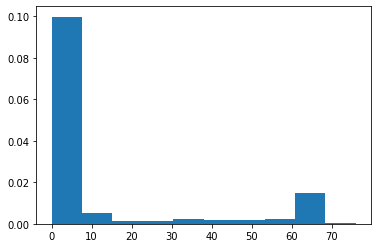

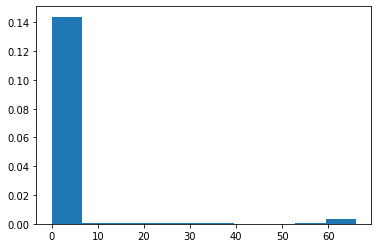

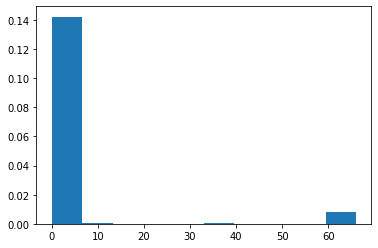

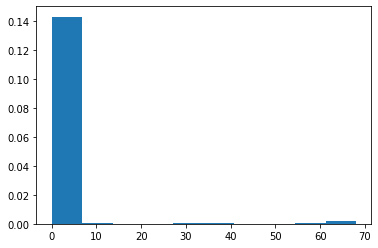

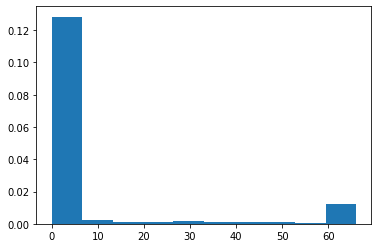

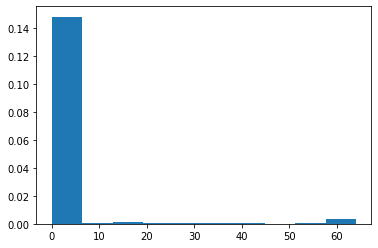

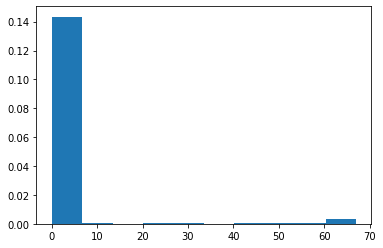

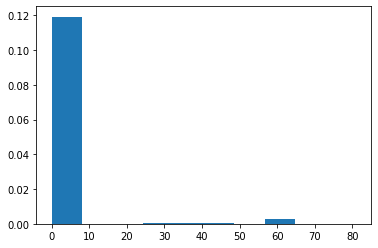

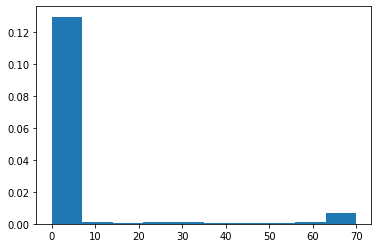

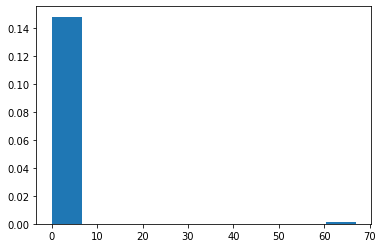

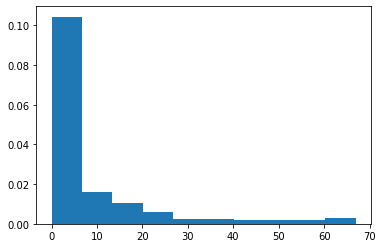

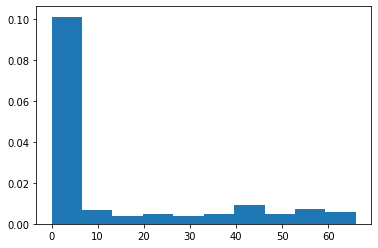

In [ ]:
features[features>0.5] = 1
features[features<=0.5] = 0

count = {i:[] for i in range(class_num)}
for i in range(len(features)):
    x = features[i]
    y = y_train[i]
    c = prototypes[int(y)]
    count[int(y)].append( ((x - c)**2).sum(axis=0) )

for k in range(class_num):
    #print("min dist : ", min(count[k]))
    #print("max dist : ", max(count[k]))
    #print("mean dist : ", sum(count[k]) / len(count[k]))    
    h = sorted(np.array(count[k]))
    plt.hist(h, density=True)
    plt.show()

In [ ]:
#**************************************************************************
#********* BUILD_INFORMATION-EXTREME_DECISION_BOUNDARIES ******************
#**************************************************************************
import math

class InformationExtremeСlassifier:

    def __init__(self, etalons=None, radiuses=None):
        self.etalons   = None
        self.radiuses  = None
        if etalons is not None :
            self.etalons  = etalons
            self.class_num   = len(etalons)
            self.feature_num = len(etalons[0])
        if radiuses is not None :
            self.radiuses = radiuses

    def compute_etalons(self, X_train, y_train):
        self.class_num = len( np.unique(y_train) )
        self.feature_num = len(X_train[0])
        self.counter = { i: 0 for i in range(self.class_num)}
        self.etalons = np.zeros((self.class_num, self.feature_num))
        self.center = np.zeros(self.feature_num)
        self.n = len(X_train)
        for i in range(self.n):
            x = X_train[i]
            class_id = y_train[i]
            self.etalons[class_id] = self.etalons[class_id] + x
            self.center = self.center + x
            self.counter[class_id] = self.counter[class_id] + 1
        self.center = self.center / self.n
        for c in range(self.class_num):
            corrected_counter = max(self.counter[c], 1)
            self.etalons[c] = self.etalons[c] / corrected_counter
            self.etalons[c] = self.etalons[c] - self.center[c] 
            self.etalons[c][ self.etalons[c]  > 0 ] = 1
            self.etalons[c][ self.etalons[c] <= 0 ] = 0
        return self.etalons

    def compute_max_radiuses(self, ):
        self.max_radius = np.ones(self.class_num)*self.feature_num
        for c in range(self.class_num):
            for k in range(self.class_num):
                distance = self.get_distance(self.etalons[c], self.etalons[k])
                if c != k :
                    if distance < self.max_radius[c] :
                        self.max_radius[c] = distance
        print("self.max_radius = ", self.max_radius)

    def criterion(self, fpr, fnr, sen, spe):
        com1 = com2 = com3 = com4 = 0
        if fpr+spe > 0 :
            com1 = fpr/(fpr+spe)
            com1 = com1*math.log2(com1) if com1>0 else 0
            com2 = spe/(fpr+spe)
            com2 = com2*math.log2(com2) if com2>0 else 0
        if fnr+sen > 0 :
            com3 = fnr/(fnr+sen)
            com3 = com3*math.log2(com3) if com3>0 else 0
            com4 = sen/(sen+fnr)
            com4 = com4*math.log2(com4) if com4>0 else 0
        return 1 + 0.5*(com1+com2+com3+com4)

    def get_distance(self, b1, b2):
        return np.count_nonzero(b1!=b2)

    def compute_distance_matrix(self, X_train):
        self.n = len(X_train)
        self.counter = { i: 0 for i in range(self.class_num)}
        for i in range(self.n):
            class_id = y_train[i]
            self.counter[class_id] = self.counter[class_id] + 1

        self.dist_matrix = np.zeros((self.class_num, self.n))
        for i in range(self.n):
            x = X_train[i]
            for c in range(self.class_num):
                e = self.etalons[c]
                self.dist_matrix[c][i] = self.get_distance(x, e)

    def compute_efficiency(self, y_train):
        for c in range(self.class_num):
            с2с = np.sort(self.dist_matrix[c][y_train==c])
            с2n = np.sort(self.dist_matrix[c][y_train!=c])
            nn = min(self.counter[c], len(с2n))
            с2n = с2n[0:nn]
            sen = len(с2с[с2с<self.radiuses[c]])
            fpr = self.counter[c] - sen
            fnr = len(с2n[с2n<self.radiuses[c]])
            spe = self.counter[c] - fnr
            sen = sen/self.counter[c]
            fpr = fpr/self.counter[c]
            fnr = fnr/self.counter[c]
            spe = spe/self.counter[c]
            E = self.criterion(fpr, fnr, sen, spe)

            print( "radius     ["+str(c)+"] : "+ str(self.radiuses[c]) )
            print( "sensitivity["+str(c)+"] : "+ str(sen) )
            print( "specificity["+str(c)+"] : "+ str(spe) )
            print( "criterion  ["+str(c)+"] : "+ str(E) )
            print( "*****************************" )

    def optimize_radiuses(self, X_train, y_train):
        self.n = len(X_train)
        self.radiuses = np.zeros(self.class_num)
        fpr = fnr = sen = spe = 0
        for c in range(self.class_num):
            с2с = np.sort(self.dist_matrix[c][y_train==c])
            с2n = np.sort(self.dist_matrix[c][y_train!=c])
            nn = min(self.counter[c], len(с2n))
            с2n = с2n[0:nn]
            E_max = 0
            for r in range(1, self.feature_num):
                sen = len(с2с[с2с<r])
                fpr = self.counter[c] - sen
                fnr = len(с2n[с2n<r])
                spe = self.counter[c] - fnr
                sen = sen/self.counter[c]
                fpr = fpr/self.counter[c]
                fnr = fnr/self.counter[c]
                spe = spe/self.counter[c]
                E = self.criterion(fpr, fnr, sen, spe)
                if sen > 0.5 and spe > 0.5 and r < self.max_radius[c]:
                     if E > E_max :
                         E_max = E
                         self.radiuses[c] = r
            print( "radius    ["+str(c)+"] : "+ str(self.radiuses[c]) )
            print( "criterion ["+str(c)+"] : "+ str(E_max) )
            print( "*****************************")
  
    def fit(self, X_train, y_train):
        self.n = len(X_train)
        if self.etalons is None :
            self.compute_etalons(X_train, y_train)
        self.compute_max_radiuses()
        self.compute_distance_matrix(X_train)
        if self.radiuses is None :
            self.optimize_radiuses(X_train, y_train)
        else :
            self.compute_distance_matrix(X_train)
            self.compute_efficiency(y_train)
        return self.etalons, self.radiuses

    def predict(self, x_test):
        result = []
        for j in range(len(x_test)):
            u = np.zeros(self.class_num)
            for c in range(self.class_num):
                e = self.etalons[c]
                dist = self.get_distance(x_test[j], e)
                u[c] = 1 - dist/self.radiuses[c]
                #u = np.exp(u)
        #u /= np.sum(u)
        #return u
            result.append( np.argmax(u) )
        result = np.array(result)
        return result


In [ ]:
classifier = InformationExtremeСlassifier(etalons=prototypes, radiuses=radiuses)

classifier.fit(features, y_train)

self.max_radius =  [61. 64. 61. 64. 63. 64. 63. 64. 64. 61. 61. 61.]
radius     [0] : 37.0
sensitivity[0] : 0.8360128617363344
specificity[0] : 0.9796355841371919
criterion  [0] : 0.6223890192249933
*****************************
radius     [1] : 53.0
sensitivity[1] : 0.9718026183282981
specificity[1] : 0.7139979859013091
criterion  [1] : 0.49678633950016937
*****************************
radius     [2] : 45.0
sensitivity[2] : 0.9468405215646941
specificity[2] : 0.9789368104312939
criterion  [2] : 0.7780088906149227
*****************************
radius     [3] : 52.0
sensitivity[3] : 0.9824380165289256
specificity[3] : 0.8450413223140496
criterion  [3] : 0.6411205677302771
*****************************
radius     [4] : 38.0
sensitivity[4] : 0.8981481481481481
specificity[4] : 0.9780092592592593
criterion  [4] : 0.6932336558298932
*****************************
radius     [5] : 44.0
sensitivity[5] : 0.9738693467336683
specificity[5] : 0.935678391959799
criterion  [5] : 0.7424277320394148
*

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 0., 1., ..., 0., 1., 0.],
        [1., 1., 0., ..., 1., 0., 0.],
        ...,
        [1., 0., 1., ..., 1., 0., 1.],
        [1., 1., 0., ..., 0., 1., 1.],
        [1., 0., 0., ..., 1., 1., 0.]], dtype=float32),
 array([37., 53., 45., 52., 38., 44., 45., 40., 47., 44., 39., 36.],
       dtype=float32))

In [ ]:
#**************************************************************************
#**************************** SAVE_RADIUSES *******************************
#**************************************************************************
from numpy import savetxt

# save to csv file
savetxt(path_to_radiuses, classifier.radiuses, delimiter=',')

In [ ]:
from sklearn.metrics import f1_score

features = []
y_test = []
for dir in os.listdir('/content/output/test'):
    for filename in os.listdir('/content/output/test'+"/"+dir) :
        if filename.endswith(".jpg") :
            img = process_image('/content/output/test'+"/"+dir+"/"+filename)
            features.append(feature_extractor.predict(img)[0])
            y_test.append( name_to_int[dir] )

features = np.array(features)
y_test = np.array(y_test)

features[features>0.5] = 1
features[features<=0.5] = 0

y_pred = classifier.predict(features)

f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='micro')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:151: RuntimeWarning: divide by zero encountered in double_scalars


(0.8113301363877611, 0.9071975063757437)

In [ ]:
# **************************************************************************************************************
# ************************************** test ******************************************************************
# **************************************************************************************************************

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import tensorflow as tf
from keras.preprocessing import image
import numpy as np

### special layer
class PrototypeLayer(tf.keras.layers.Layer):
  
    def __init__(self, prototypes=prototypes, radiuses=radiuses, **kwargs):
        super().__init__(**kwargs)
        self.centers     = tf.constant(prototypes, dtype=tf.float32)
        self.radiuses    = tf.constant(radiuses, dtype=tf.float32)
        self.dim         = tf.constant(prototypes.shape[1], dtype=tf.float32)
        self.num_classes = tf.constant(prototypes.shape[0], dtype=tf.float32)
        self.one         = tf.constant(1, dtype=tf.float32)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, embedding, mask=None):
        batch_size          = embedding.shape[0]
        if batch_size is None:
            batch_size = 1
        expanded_centers    = tf.expand_dims(self.centers, axis=0)   
        expanded_centers    = tf.repeat( expanded_centers, repeats=[batch_size], axis=0 )        
        expanded_embedding  = tf.expand_dims( embedding, axis=1 )
        expanded_embedding  = tf.repeat( expanded_embedding, repeats=[self.num_classes], axis=1 ) 
        distance_centers    = tf.math.squared_difference( expanded_embedding, expanded_centers )
        distance_centers    = tf.math.reduce_sum( distance_centers, axis=2 )
        self.u  = tf.nn.relu(self.one-(distance_centers /self.radiuses))
        self.u  = tf.nn.sigmoid(6 * self.u)
        return self.u

    def compute_output_shape(self, input_shape):
        return tf.compat.v1.keras.backend.int_shape(self.loss)

def create_base_network():
    x = extractor.output
    out = PrototypeLayer(prototypes=prototypes, radiuses=radiuses)(x)
    return tf.keras.models.Model(inputs=extractor.input, outputs=out)

def process_image(img_path):
    img = image.load_img(img_path, target_size=(image_size, image_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    pImg = tf.keras.applications.mobilenet.preprocess_input(img_array)
    return pImg

class_num                 = 12
image_size                = 224

labels                    = {0 : 'collapse',
                             1 : 'forward',
                             2 : 'ignore',
                             3 : 'manhole',
                             4 : 'semi_down',
                             5 : 'semi_left',
                             6 : 'semi_right',
                             7 : 'semi_up',
                             8 : 'side',
                             9 : 'tap_capped',
                             10: 'tap_open_TO__TB',
                             11: 'tap_open_T__TF'}

path_to_feature_extractor = 'gdrive/MyDrive/feature_extractor.h5'
path_to_prototypes        = 'gdrive/MyDrive/prototypes.csv'
path_to_radiuses          = 'gdrive/MyDrive/radiuses.csv'

extractor    = tf.keras.models.load_model(path_to_feature_extractor)
radiuses     = np.loadtxt(path_to_radiuses, delimiter=',')
prototypes   = np.loadtxt(path_to_prototypes, delimiter=',')

classifer = create_base_network()

classifer.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 encoder (Functional)        (None, 128)               895072    
                                                                 
 main_out (Dense)            (None, 128)               16512     
                                                                 
 prototype_layer_21 (Prototy  (None, 12)               0         
 peLayer)                                                        
                                                                 
Total params: 911,584
Trainable params: 900,640
Non-trainable params: 10,944
_________________________________________________________________


side 0.9974963


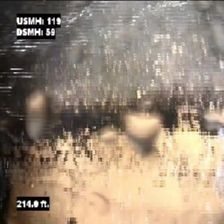

In [ ]:
img_path = dataset_dir_path+"/"+"tmp6mq183az.jpg"
img = process_image(img_path)
pred = classifer.predict(img)[0]
index = np.argmax(pred)
print(labels[index], pred[index])

from google.colab.patches import cv2_imshow
img_cv2 = cv2.imread(img_path)
cv2_imshow(img_cv2)

In [ ]:
dataset_dir_path = 'context_dataset_originals_v1.0/context_dataset_originals/side'

os.listdir(dataset_dir_path)[:10]

['tmp5wwllld3.jpg',
 'tmpbrtca9rk.jpg',
 'tmpdrj83ldf.jpg',
 'tmp6mq183az.jpg',
 '(20150904) S196-100_S196-102 (Downstream) CM@205.jpg',
 'tmps34qu0t3.jpg',
 'tmpmts422wb.jpg',
 'tmpf5ngaw4a.jpg',
 "STJ007-1_20210420_TV219_RH-AMH 'G-10-10'-AMH 'G-10-05'-527 E JAMES BLVD_105150.jpg",
 'tmpha6zyddv.jpg']